# Variational Gaussian Process Classification (白色化なし)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

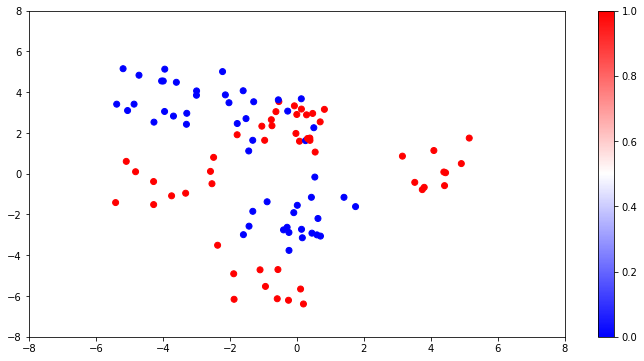

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
estimator = VGP(X, y, kernel, likelihood, whiten = False)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 10000
for epoch in range(n_epochs):
    loss = svi.step()
    if epoch % (n_epochs / 10) == 0:
        print(loss)

1639576.5991699526
2039.240993985557
302.87271155265114
244.23552371053688
273.41912892693455
151.52761308933665
132.28291365301402
107.05871713063104
124.91111800677388
86.74086858787712


---

## 推論結果

### 予測分布

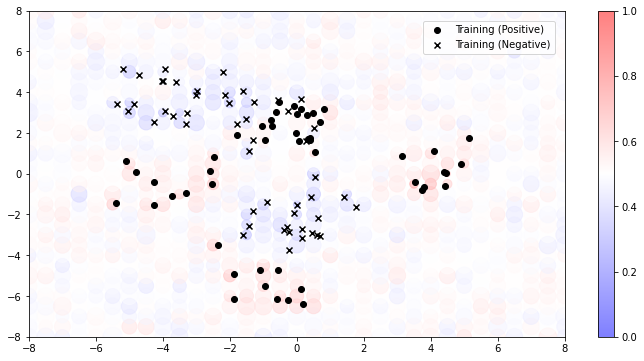

CPU times: user 767 ms, sys: 100 ms, total: 868 ms
Wall time: 594 ms


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(0.2792, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.f_loc

Parameter containing:
tensor([[ 0.3066, -0.5897,  0.4754, -0.4879,  0.4513, -0.4069,  0.6352, -0.4106,
          0.0976, -0.5204,  0.3702, -0.1365,  0.6664, -0.4992,  0.3561, -0.4397,
          0.5724, -0.5245,  0.0413, -0.5183,  0.3887, -0.4319,  0.7446, -0.1052,
          0.2984, -0.6961,  0.3087, -0.5724,  0.2183, -0.4299,  0.0306, -0.4670,
          0.4643,  0.0159,  0.3807, -0.5683,  0.6229, -0.2091,  0.0152, -0.5002,
          0.0954, -0.5120,  0.8040, -0.2820,  0.5007, -0.5593,  0.5354, -0.4734,
          0.1064, -0.0451,  0.1595, -0.2992,  0.8605, -0.0274,  0.4029, -0.5856,
          0.6558, -0.4347,  0.0150, -0.6639,  0.2438, -0.7079,  0.7220, -0.0174,
          0.4243, -0.4209,  0.3739, -0.5672,  0.2836, -0.5774,  0.2472, -0.4777,
          0.5622, -0.3302,  0.5695, -0.5665,  0.4224, -0.0577,  0.0680, -0.0662,
          0.0374, -0.6222,  0.4243, -0.4913,  0.4246, -0.0767,  0.3489, -0.3904,
          0.0439, -0.4554,  0.1373, -0.4048,  0.3890, -0.3751,  0.5215, -0.6929,
      

In [12]:
estimator.f_cov

tensor([[[ 6.5240e-01,  2.4641e-02,  9.1098e-03,  ..., -5.0202e-04,
          -4.9524e-03,  1.4470e-02],
         [ 2.4641e-02,  8.4217e-01,  3.9802e-02,  ..., -1.2256e-02,
           9.6411e-03, -1.6858e-02],
         [ 9.1098e-03,  3.9802e-02,  8.9722e-01,  ...,  2.3229e-02,
           1.2887e-02, -2.2817e-02],
         ...,
         [-5.0202e-04, -1.2256e-02,  2.3229e-02,  ...,  5.3249e-01,
           2.0179e-02, -2.8077e-02],
         [-4.9524e-03,  9.6411e-03,  1.2887e-02,  ...,  2.0179e-02,
           6.9996e-01, -1.1636e-01],
         [ 1.4470e-02, -1.6858e-02, -2.2817e-02,  ..., -2.8077e-02,
          -1.1636e-01,  1.1496e+00]]], grad_fn=<UnsafeViewBackward>)